In [75]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
import itertools
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,max_error

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge


# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
df = pd.read_excel("finaldata.xlsx")

In [4]:
df.drop_duplicates(subset=['TimeStamp'])

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.280,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.180,1,1,1,1
2,2019-01-01 02:00:00,1993.39,2613.60,513.24,0.4485,123.4,0.0,35.5,224.6,616.3,8.4,82.0,60.910,1,1,2,1
3,2019-01-01 03:00:00,1752.69,2470.13,489.53,0.4832,124.1,0.0,35.6,190.7,451.6,8.6,82.0,65.160,1,1,3,1
4,2019-01-01 04:00:00,1717.17,2384.35,378.44,0.4460,124.4,0.0,36.0,197.1,458.5,8.4,85.0,65.160,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30615,2022-06-29 19:00:00,3978.34,3879.64,367.16,0.0931,116.3,456.0,146.4,96.5,1658.4,15.8,73.0,245.195,29,6,19,2
30616,2022-06-29 20:00:00,3843.57,3725.62,311.32,0.0751,92.3,450.7,123.8,93.6,1678.3,14.5,80.0,245.195,29,6,20,2
30617,2022-06-29 21:00:00,3796.31,3601.76,290.98,0.0668,80.5,450.7,122.2,93.6,1649.8,14.0,77.0,228.590,29,6,21,2
30618,2022-06-29 22:00:00,3754.00,3467.82,309.83,0.0732,59.7,340.1,121.5,96.1,1630.2,13.3,82.0,228.590,29,6,22,2


In [15]:
data=df.copy()
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
#data = data.set_index('TimeStamp')
#data = data.asfreq('H')
#data = data.sort_index()
data.head(2)

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.28,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.18,1,1,1,1


In [16]:
data=data.fillna(method='ffill')
data['ElectricityPrice'] = data['ElectricityPrice'].fillna(0)
data['IE Demand'] = data['IE Demand'].fillna(0)

In [18]:
data=data.drop(data[data['TimeStamp']>pd.to_datetime('31-12-2021  23:00:00')].index)
data.shape

(26301, 17)

In [20]:
min_date = data['TimeStamp'].min()
max_date = data['TimeStamp'].max()
print("Min:", min_date, "Max:", max_date)
train_percent = .80
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Min: 2019-01-01 00:00:00 Max: 2021-12-31 23:00:00


Timestamp('2021-05-26 18:24:00')

In [22]:
train_df = data[data['TimeStamp'] <= train_cutoff]
test_df = data[data['TimeStamp'] > train_cutoff]


print("Train:", train_df.index.min(), train_df.index.max(), len(train_df))
print("Test:", test_df.index.min(), test_df.index.max(), len(test_df))

Train: 0 21039 21040
Test: 21040 26300 5261


In [23]:
train_df=train_df.drop(columns=['ElectricityPrice'])
test_df=test_df.drop(columns=['ElectricityPrice'])

In [29]:
exogenous_features = list(data)
exogenous_features.remove('IE Demand')
exogenous_features.remove('ElectricityPrice')
exogenous_features.remove('TimeStamp')
exogenous_features

['IE Generation',
 'IE Wind Generation',
 'SNSP',
 'Hydro Run-of-River',
 'Fossil hard coal',
 'Fossil oil',
 'Fossil peat',
 'Fossil gas',
 'temp',
 'rhum',
 'day',
 'month',
 'hour',
 'dayofweek']

In [33]:
from prophet import Prophet
model = Prophet()

In [34]:
for feature in exogenous_features:
	model.add_regressor(feature)

In [35]:
train_df.head(2)

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,day,month,hour,dayofweek
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,1,1,1,1


In [36]:
model.fit(train_df[["TimeStamp", "IE Demand"] + exogenous_features].rename(columns={"TimeStamp": "ds", "IE Demand": "y"}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp45ciaugg/k_0u7o41.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp45ciaugg/66avud1c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22709', 'data', 'file=/tmp/tmp45ciaugg/k_0u7o41.json', 'init=/tmp/tmp45ciaugg/66avud1c.json', 'output', 'file=/tmp/tmp45ciaugg/prophet_model42t05p5o/prophet_model-20230628120443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:04:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [37]:
forecast = model.predict(test_df[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

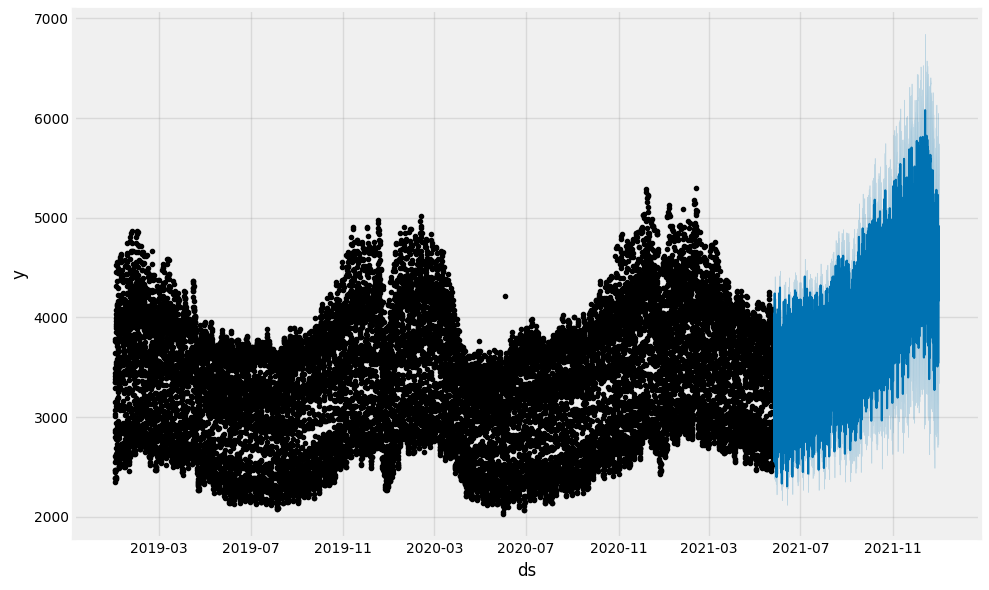

In [38]:
fig1 = model.plot(forecast)

In [42]:
test_df.head(2)

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,day,month,hour,dayofweek
21040,2021-05-26 19:00:00,3048.61,3807.30,166.50,0.2488,122.4,626.9,549.2,113.1,232.1,13.2,63.0,26,5,19,2
21041,2021-05-26 20:00:00,3099.42,3668.78,176.91,0.2139,126.9,626.9,500.5,117.2,176.4,12.4,71.0,26,5,20,2


In [44]:
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Fossil gas,Fossil gas_lower,Fossil gas_upper,Fossil hard coal,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-26 19:00:00,3783.320997,3836.365189,4164.916009,3783.320997,3783.320997,-2.147879,-2.147879,-2.147879,-21.648636,...,48.968599,48.968599,48.968599,-229.351902,-229.351902,-229.351902,0.0,0.0,0.0,4005.382424
1,2021-05-26 20:00:00,3783.431488,3737.525949,4097.794222,3783.431488,3783.431488,-2.323714,-2.323714,-2.323714,-21.648636,...,50.027415,50.027415,50.027415,-229.365061,-229.365061,-229.365061,0.0,0.0,0.0,3915.845567


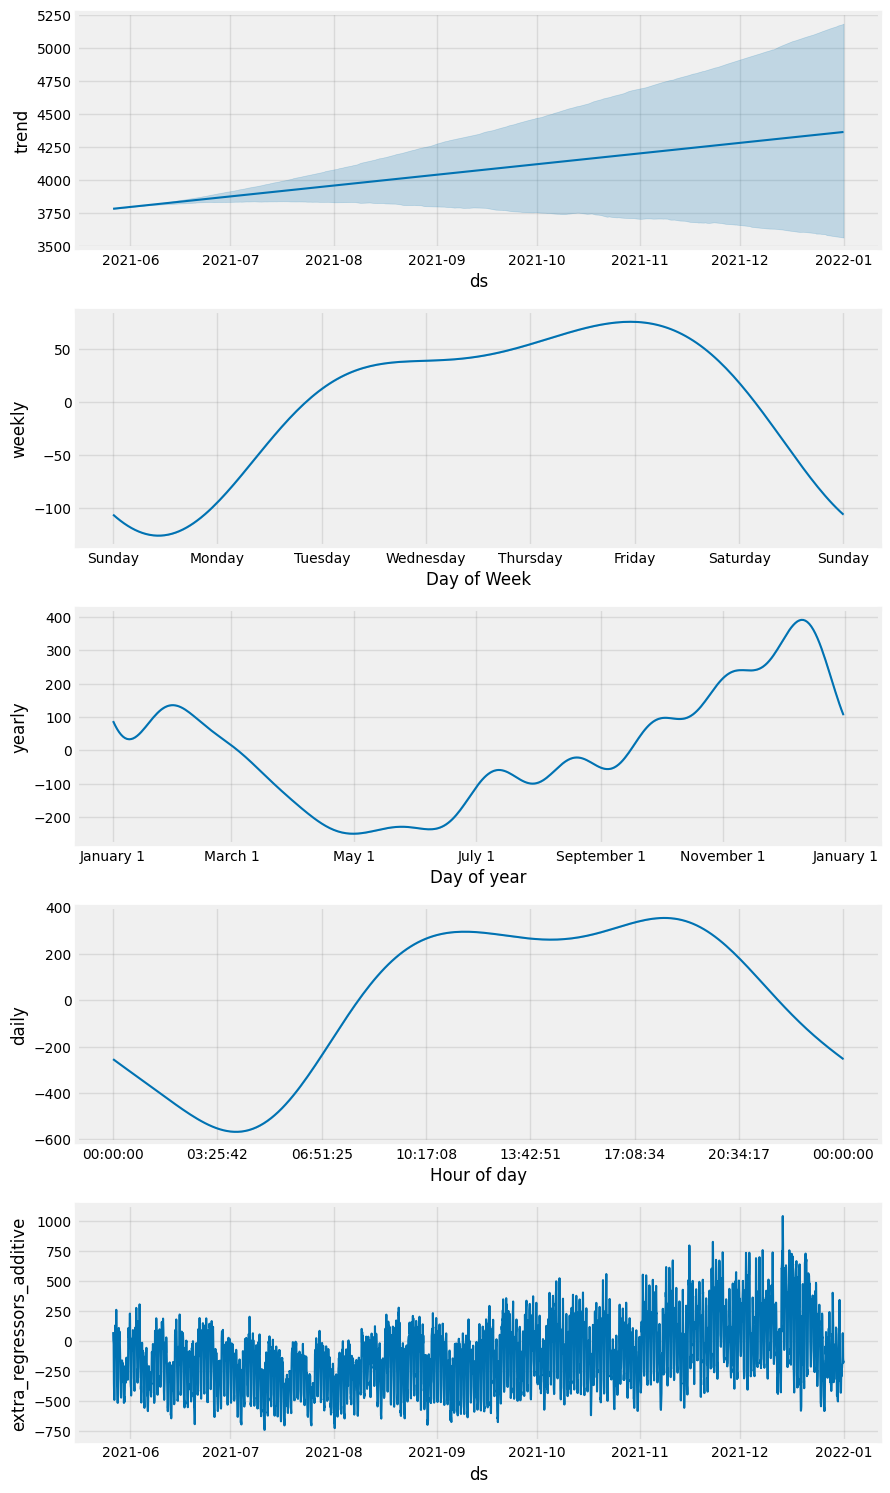

In [41]:
fig2 = model.plot_components(forecast)

In [55]:
result = forecast.copy()

In [61]:
result.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Fossil gas,Fossil gas_lower,Fossil gas_upper,Fossil hard coal,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2021-05-26 19:00:00,2021-05-26 19:00:00,3783.320997,3836.365189,4164.916009,3783.320997,3783.320997,-2.147879,-2.147879,-2.147879,-21.648636,...,48.968599,48.968599,48.968599,-229.351902,-229.351902,-229.351902,0.0,0.0,0.0,4005.382424
2021-05-26 20:00:00,2021-05-26 20:00:00,3783.431488,3737.525949,4097.794222,3783.431488,3783.431488,-2.323714,-2.323714,-2.323714,-21.648636,...,50.027415,50.027415,50.027415,-229.365061,-229.365061,-229.365061,0.0,0.0,0.0,3915.845567


In [58]:
result['TimeStamp'] = pd.to_datetime(result['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result = result.set_index('TimeStamp')
result = result.asfreq('H')
result = result.sort_index()

In [63]:
dftest = test_df.copy()

In [65]:
dftest['TimeStamp'] = pd.to_datetime(dftest['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
dftest = dftest.set_index('TimeStamp')
dftest = dftest.asfreq('H')
dftest = dftest.sort_index()

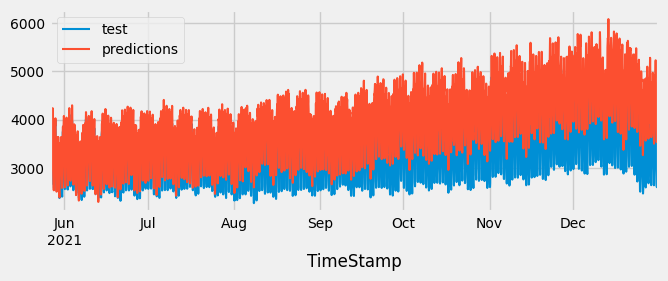

In [69]:
fig, ax = plt.subplots(figsize=(7, 2.5))

dftest['IE Demand'].plot(ax=ax, label='test')
#forecast['yhat_lower'].plot(ax=ax, label='lower')
#forecast['yhat_upper'].plot(ax=ax, label='upper')
result['yhat'].plot(ax=ax, label='predictions')
ax.legend();

In [72]:
r2_score(test_df['IE Demand'], forecast['yhat'])

0.1005685907411642

In [74]:
mean_squared_error(test_df['IE Demand'], forecast['yhat'])

346451.2644992981

In [73]:
mean_absolute_error(test_df['IE Demand'], forecast['yhat'])

517.4202088283919

In [79]:
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [80]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_df[["TimeStamp", "IE Demand"] + exogenous_features].rename(columns={"TimeStamp": "ds", "IE Demand": "y"}))  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp45ciaugg/dywyi015.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp45ciaugg/jqlj967p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58632', 'data', 'file=/tmp/tmp45ciaugg/dywyi015.json', 'init=/tmp/tmp45ciaugg/jqlj967p.json', 'output', 'file=/tmp/tmp45ciaugg/prophet_modelp5wmyum1/prophet_model-20230628124708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:47:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2020-01-02 18:00:00 and 2021-04-26 18:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f2284809de0>
DEBUG:cmdstanpy:input tempfile:

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  249.353066
1                     0.001                     0.10  251.536153
2                     0.001                     1.00  250.220674
3                     0.001                    10.00  249.259311
4                     0.010                     0.01  265.263415
5                     0.010                     0.10  261.498499
6                     0.010                     1.00  263.622138
7                     0.010                    10.00  262.612267
8                     0.100                     0.01  293.504444
9                     0.100                     0.10  367.832755
10                    0.100                     1.00  350.290045
11                    0.100                    10.00  356.085760
12                    0.500                     0.01  337.014049
13                    0.500                     0.10  448.301269
14                    0.5

In [81]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}


In [86]:
model2 = Prophet(changepoint_prior_scale = 0.001, seasonality_prior_scale= 10.0)

In [87]:
for feature in exogenous_features:
	model2.add_regressor(feature)

In [90]:
model2.fit(train_df[["TimeStamp", "IE Demand"] + exogenous_features].rename(columns={"TimeStamp": "ds", "IE Demand": "y"}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp45ciaugg/ymbaxg3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp45ciaugg/ibs9ap7l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12859', 'data', 'file=/tmp/tmp45ciaugg/ymbaxg3k.json', 'init=/tmp/tmp45ciaugg/ibs9ap7l.json', 'output', 'file=/tmp/tmp45ciaugg/prophet_modelvw7y_i35/prophet_model-20230628141230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [91]:
forecast2 = model2.predict(test_df[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

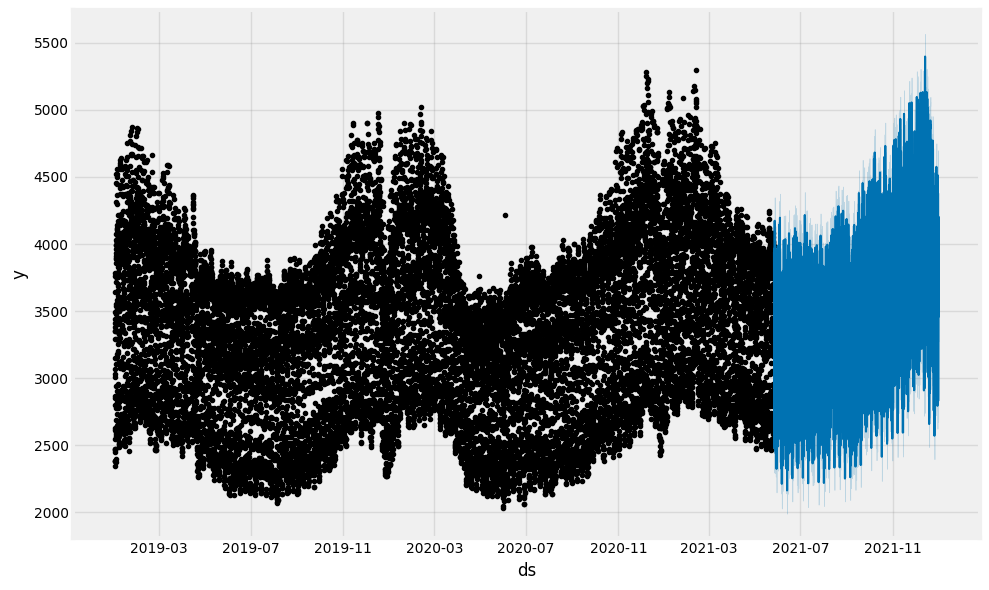

In [92]:
fig3 = model2.plot(forecast2)

In [94]:
forecast2.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Fossil gas,Fossil gas_lower,Fossil gas_upper,Fossil hard coal,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-26 19:00:00,3605.955642,3767.858931,4102.045382,3605.955642,3605.955642,19.212830,19.212830,19.212830,-28.717673,...,47.671081,47.671081,47.671081,-120.571985,-120.571985,-120.571985,0.0,0.0,0.0,3941.092812
1,2021-05-26 20:00:00,3605.988838,3677.081295,4023.118588,3605.988838,3605.988838,20.785679,20.785679,20.785679,-28.717673,...,48.670420,48.670420,48.670420,-120.665205,-120.665205,-120.665205,0.0,0.0,0.0,3854.879929


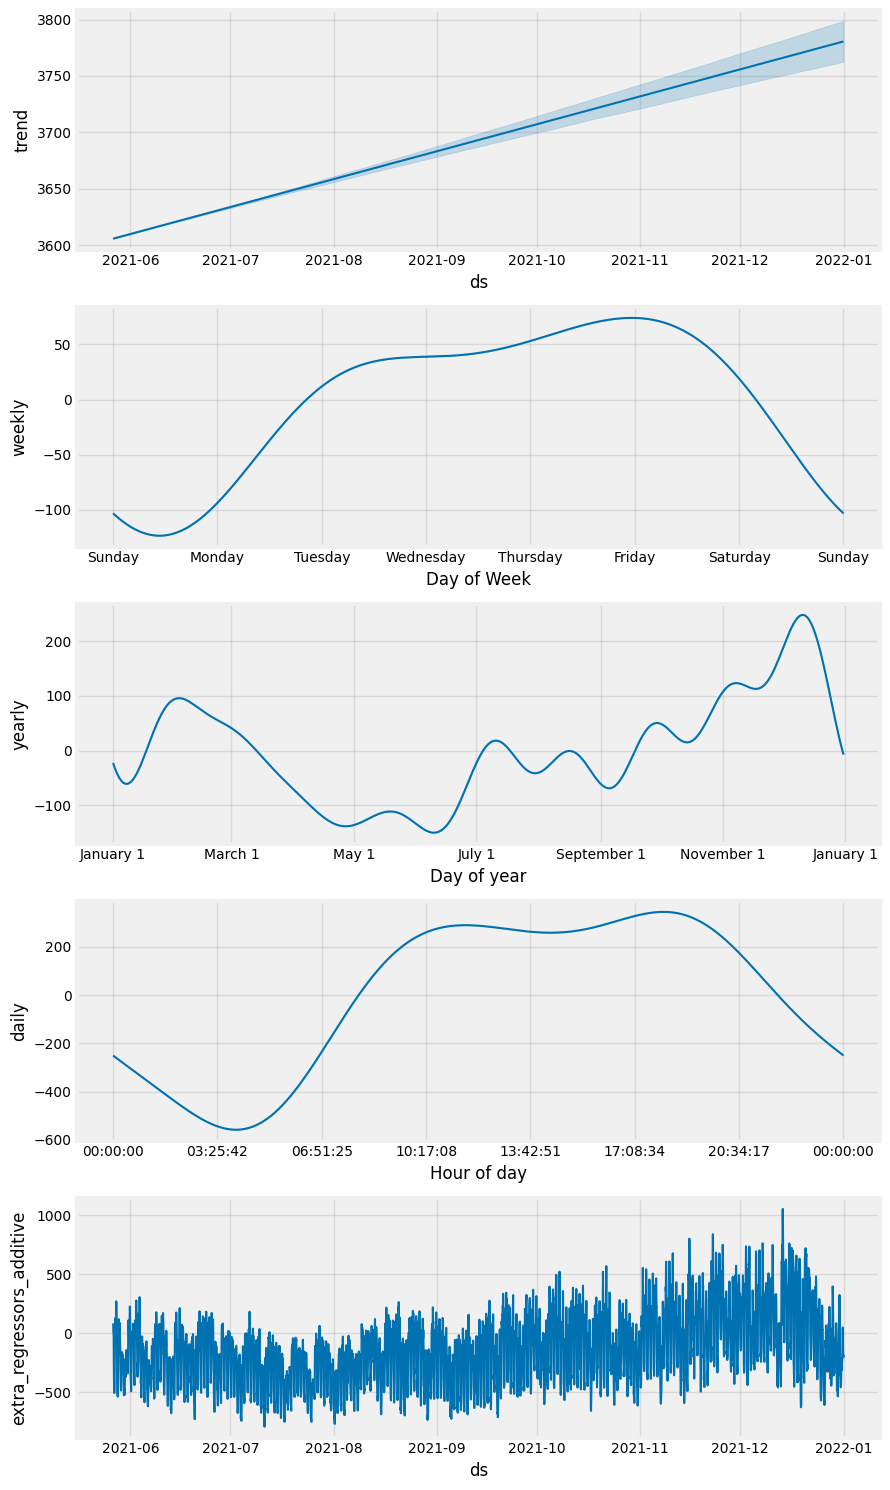

In [95]:
fig4 = model2.plot_components(forecast2)

In [96]:
result2 = forecast2.copy()

In [97]:
result2.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Fossil gas,Fossil gas_lower,Fossil gas_upper,Fossil hard coal,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-26 19:00:00,3605.955642,3767.858931,4102.045382,3605.955642,3605.955642,19.212830,19.212830,19.212830,-28.717673,...,47.671081,47.671081,47.671081,-120.571985,-120.571985,-120.571985,0.0,0.0,0.0,3941.092812
1,2021-05-26 20:00:00,3605.988838,3677.081295,4023.118588,3605.988838,3605.988838,20.785679,20.785679,20.785679,-28.717673,...,48.670420,48.670420,48.670420,-120.665205,-120.665205,-120.665205,0.0,0.0,0.0,3854.879929


In [98]:
result2['TimeStamp'] = pd.to_datetime(result2['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result2 = result2.set_index('TimeStamp')
result2 = result2.asfreq('H')
result2 = result2.sort_index()

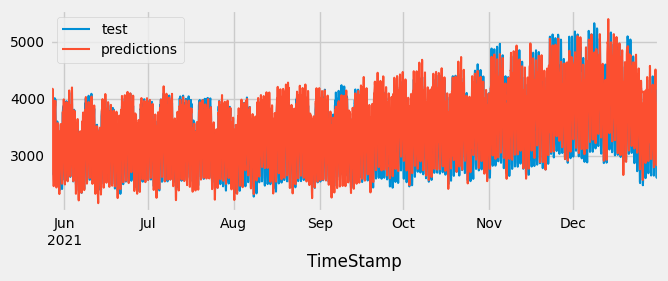

In [100]:
fig, ax = plt.subplots(figsize=(7, 2.5))

dftest['IE Demand'].plot(ax=ax, label='test')
#forecast['yhat_lower'].plot(ax=ax, label='lower')
#forecast['yhat_upper'].plot(ax=ax, label='upper')
result2['yhat'].plot(ax=ax, label='predictions')
ax.legend();

In [101]:
r2_score(test_df['IE Demand'], forecast2['yhat'])

0.9222144576811814

In [102]:
mean_squared_error(test_df['IE Demand'], forecast2['yhat'])

29962.15077514943

In [103]:
mean_absolute_error(test_df['IE Demand'], forecast2['yhat'])

138.2621238388964

In [104]:
pred_data=df.copy()
pred_data['TimeStamp'] = pd.to_datetime(pred_data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')

In [105]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']<=pd.to_datetime('31-12-2021  23:00:00')].index)
pred_data.shape

(4319, 17)

In [110]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']>pd.to_datetime('01-07-2022  00:00:00')].index)
pred_data.shape

(145, 17)

In [112]:
forecast3 = model2.predict(pred_data[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

In [119]:
result3 = forecast3.copy()

In [120]:
result3['TimeStamp'] = pd.to_datetime(result3['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result3 = result3.set_index('TimeStamp')
result3 = result3.asfreq('H')
result3 = result3.sort_index()

In [122]:
pred_data = pred_data.set_index('TimeStamp')
pred_data = pred_data.asfreq('H')
pred_data = pred_data.sort_index()

In [128]:
plottest=dftest.drop(dftest[dftest.index<pd.to_datetime('30-11-2021  23:00:00')].index)

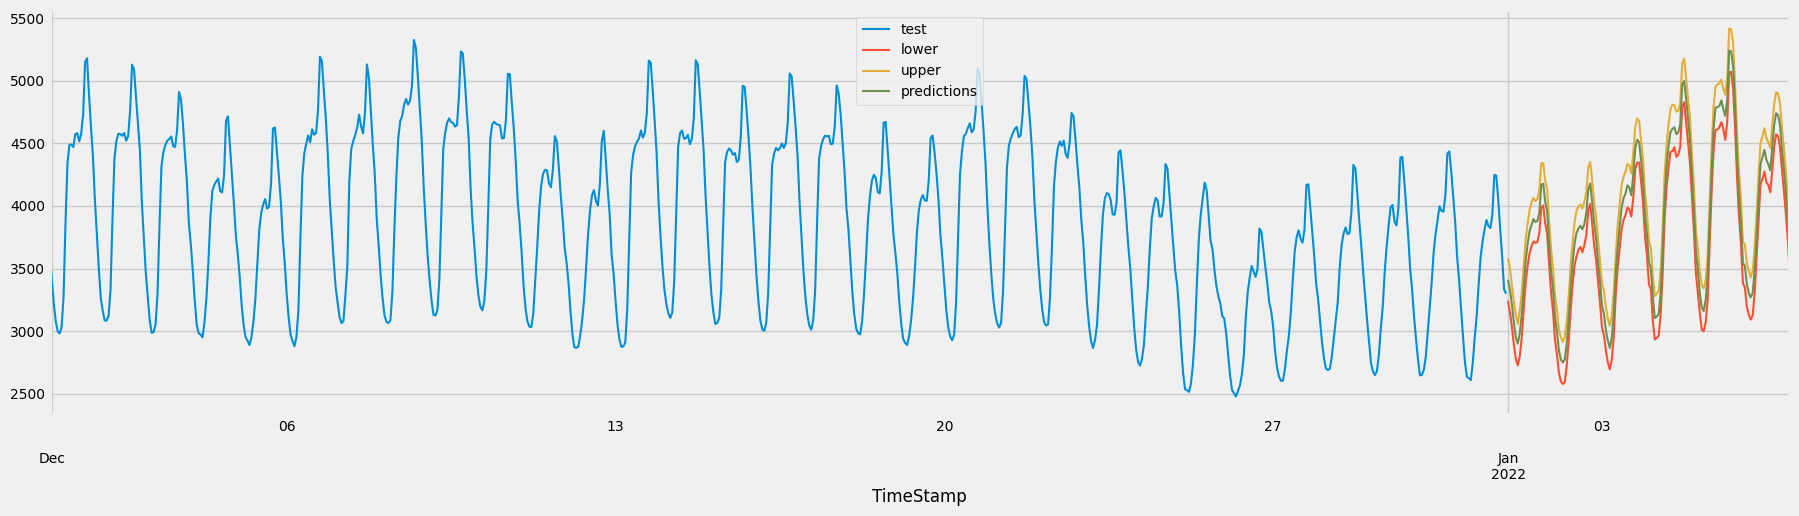

In [136]:
fig, ax = plt.subplots(figsize=(20, 5))

#pred_data['IE Demand'].plot(ax=ax, label='test')
plottest['IE Demand'].plot(ax=ax, label='test')
result3['yhat_lower'].plot(ax=ax, label='lower')
result3['yhat_upper'].plot(ax=ax, label='upper')
result3['yhat'].plot(ax=ax, label='predictions')
ax.fill_between(result3['yhat'],result3['yhat_upper'],result3['yhat_lower'], color='blue', alpha=0.1)
ax.legend();
plt.show()

In [140]:
pred_data2=df.copy()
pred_data2['TimeStamp'] = pd.to_datetime(pred_data2['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
pred_data2=pred_data2.drop(pred_data2[pred_data2['TimeStamp']<=pd.to_datetime('31-12-2021  23:00:00')].index)
pred_data2=pred_data2.drop(pred_data2[pred_data2['TimeStamp']>=pd.to_datetime('01-02-2022  00:00:00')].index)
pred_data2.shape

(24, 17)

In [141]:
forecast4 = model2.predict(pred_data2[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

In [142]:
pred_data2 = pred_data2.set_index('TimeStamp')
pred_data2 = pred_data2.asfreq('H')
pred_data2 = pred_data2.sort_index()

In [143]:
result4=forecast4.copy()
result4['TimeStamp'] = pd.to_datetime(result4['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result4 = result4.set_index('TimeStamp')
result4 = result4.asfreq('H')
result4 = result4.sort_index()

In [147]:
plottest=dftest.drop(dftest[dftest.index<pd.to_datetime('28-12-2021  23:00:00')].index)

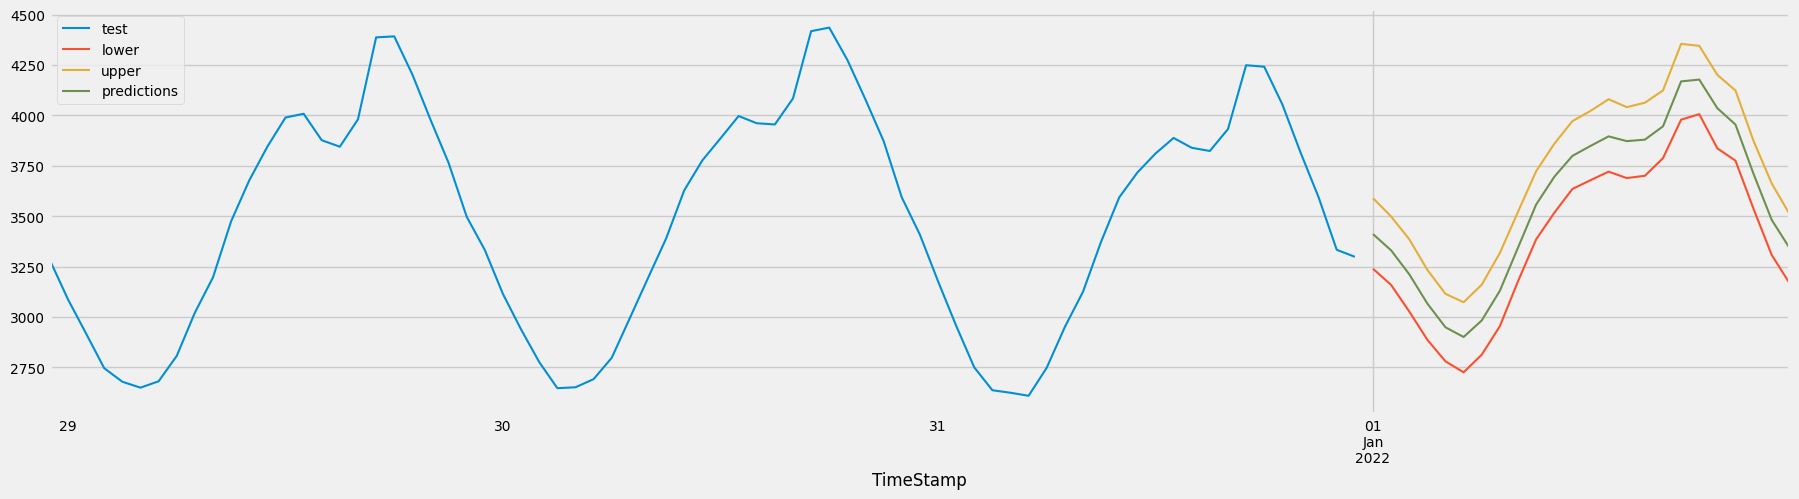

In [148]:
fig, ax = plt.subplots(figsize=(20, 5))

#pred_data['IE Demand'].plot(ax=ax, label='test')
plottest['IE Demand'].plot(ax=ax, label='test')
result4['yhat_lower'].plot(ax=ax, label='lower')
result4['yhat_upper'].plot(ax=ax, label='upper')
result4['yhat'].plot(ax=ax, label='predictions')
#ax.fill_between(result3['yhat'],result3['yhat_upper'],result3['yhat_lower'], color='blue', alpha=0.1)
ax.legend();
plt.show()